<a href="https://colab.research.google.com/github/sayyamalam/looper-dashboard/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True


In [5]:
# === 0) Pfade anpassen ===
BASE = Path("/content/sign-language-recognition/meta/cleaned")  # z.B. meta/cleaned oder nur meta
TRAIN_JSON = BASE / "MSASL_train_clean.json"
VAL_JSON   = BASE / "MSASL_val_clean.json"
TEST_JSON  = BASE / "MSASL_test_clean.json"

OUT_DIR = Path("meta/selected50")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# Mapping Label-ID -> Wort (falls vorhanden; sonst wird ohne Mapping gearbeitet)
CLASSES_JSON = Path("meta/MSASL_classes.json")
label_to_word = {}
if CLASSES_JSON.exists():
    try:
        with open(CLASSES_JSON, "r") as f:
            label_to_word = {int(k): v for k, v in json.load(f).items()}
    except Exception:
        label_to_word = {}

In [7]:
# === 1) Laden ===
use_cols = ["org_text","clean_text","start_time","end_time","fps","width","height",
            "label","signer_id","url","box"]
def load_df(p):
    df = pd.read_json(p)
    # einige Dateien haben evtl. 'review' o.ä. Spalten
    keep = [c for c in use_cols if c in df.columns]
    df = df[keep].copy()
    # Dauer in Sekunden
    if "start_time" in df and "end_time" in df:
        df["duration_s"] = df["end_time"] - df["start_time"]
    return df

df_train = load_df(TRAIN_JSON)
df_val   = load_df(VAL_JSON)
df_test  = load_df(TEST_JSON)

for name, df in [("train", df_train), ("val", df_val), ("test", df_test)]:
    print(f"{name:>5}: {len(df):6d} clips | labels={df['label'].nunique()} | signers={df['signer_id'].nunique()}")

train:  12805 clips | labels=1000 | signers=128
  val:   3297 clips | labels=932 | signers=26
 test:   2847 clips | labels=944 | signers=14


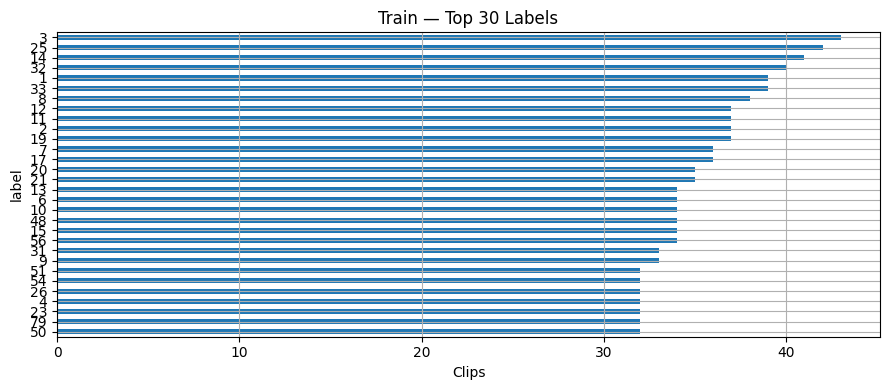

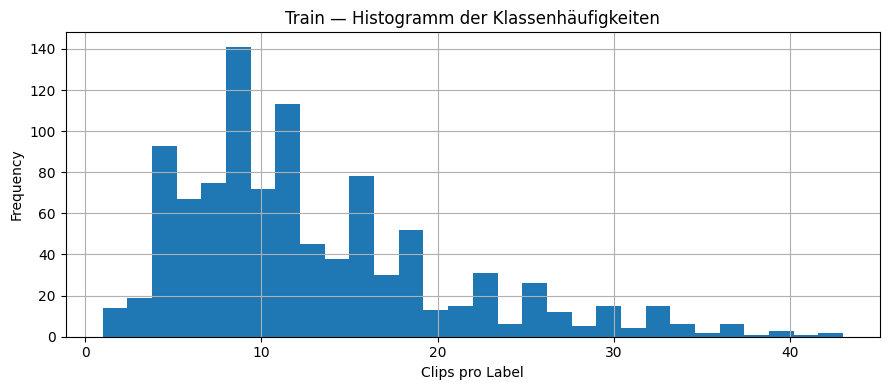

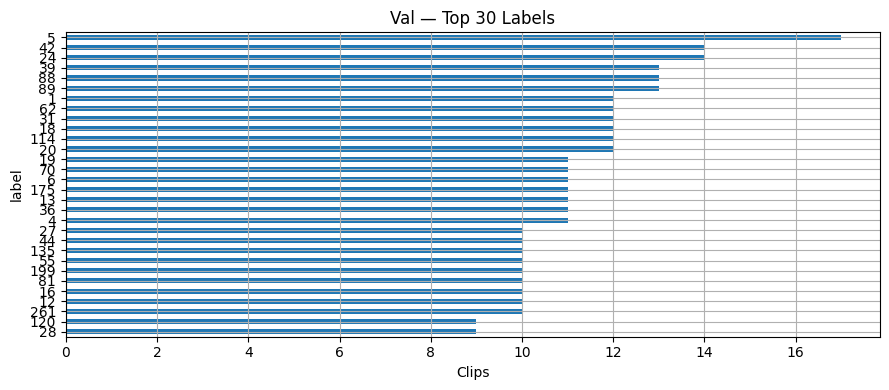

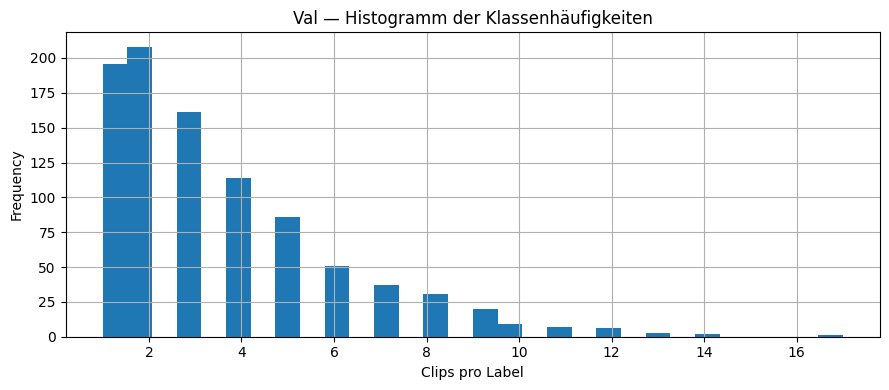

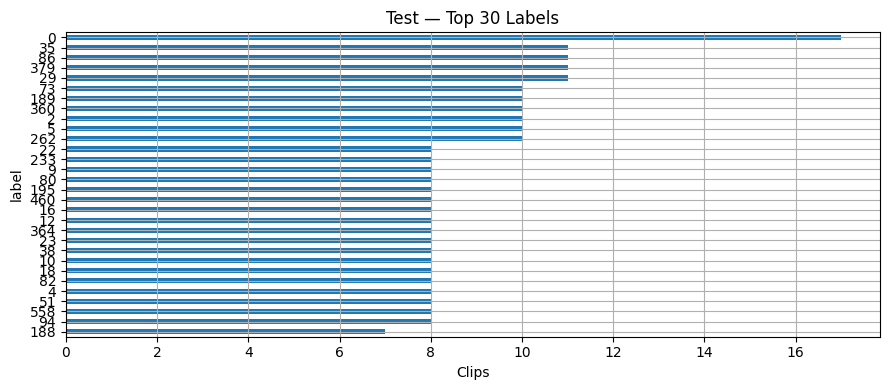

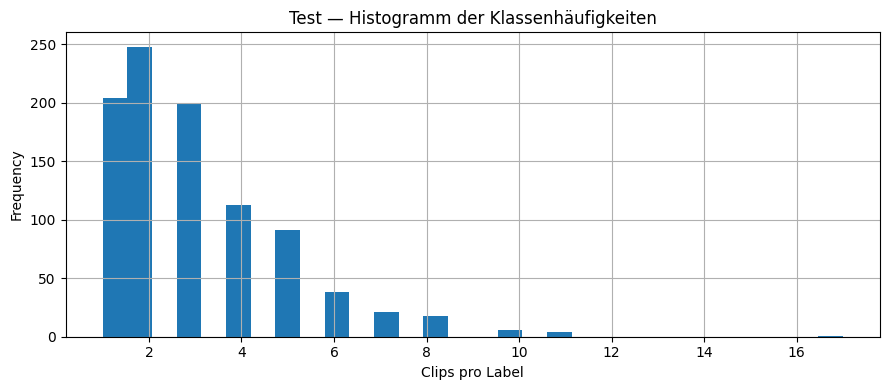


Train – Numeric summary
       duration_s       fps     width    height
count    12805.00  12805.00  12805.00  12805.00
mean         3.30     28.60    697.23    418.90
std          1.45      2.44    282.12    142.21
min          0.27      7.43    202.00    218.00
10%          1.67     25.00    480.00    360.00
50%          3.00     29.97    640.00    360.00
90%          5.24     30.00   1280.00    720.00
max         11.60     30.01   1280.00    720.00

Val – Numeric summary
       duration_s      fps    width   height
count     3297.00  3297.00  3297.00  3297.00
mean         3.02    27.21   912.30   519.35
std          1.24     4.83   342.26   176.38
min          0.43    15.00   320.00   240.00
10%          1.57    15.00   480.00   360.00
50%          2.93    29.97   640.00   360.00
90%          4.67    30.00  1280.00   720.00
max          9.01    30.00  1280.00   720.00

Test – Numeric summary
       duration_s      fps    width   height
count     2847.00  2847.00  2847.00  2847.00
m

In [8]:
# === 2) EDA – Labelverteilungen & Basisstatistik ===
def plot_label_counts(df, title, top_k=30, bins=30):
    counts = df["label"].value_counts()
    # Top K
    top = counts.head(top_k).sort_values()
    ax = top.plot(kind="barh")
    ax.set_title(f"{title} — Top {top_k} Labels")
    ax.set_xlabel("Clips")
    plt.tight_layout(); plt.show()
    # Histogramm (wie viele Klassen haben wie viele Clips)
    ax = counts.plot(kind="hist", bins=bins)
    ax.set_title(f"{title} — Histogramm der Klassenhäufigkeiten")
    ax.set_xlabel("Clips pro Label")
    plt.tight_layout(); plt.show()

plot_label_counts(df_train, "Train", top_k=30, bins=30)
plot_label_counts(df_val,   "Val",   top_k=30, bins=30)
plot_label_counts(df_test,  "Test",  top_k=30, bins=30)

def describe_numeric(df, name):
    if {"duration_s","fps","width","height"}.issubset(df.columns):
        print(f"\n{name} – Numeric summary")
        print(df[["duration_s","fps","width","height"]]
              .describe(percentiles=[.1,.5,.9]).round(2))

describe_numeric(df_train, "Train")
describe_numeric(df_val,   "Val")
describe_numeric(df_test,  "Test")

In [9]:
# === 3) Schnittmengen-Check (Coverage) ===
L_tr = set(df_train["label"].unique())
L_va = set(df_val["label"].unique())
L_te = set(df_test["label"].unique())
print("\nLabels in ALLEN Splits:", len(L_tr & L_va & L_te))
print("Nur Train:", len(L_tr - (L_va | L_te)))
print("Nur Val:",   len(L_va - (L_tr | L_te)))
print("Nur Test:",  len(L_te - (L_tr | L_va)))


Labels in ALLEN Splits: 884
Nur Train: 8
Nur Val: 0
Nur Test: 0


In [10]:
# === 4) Auswahl-Regel:
#     "Top-50 nach Häufigkeit in Train, die gleichzeitig in Val & Test vorkommen"
train_counts = df_train["label"].value_counts()
labels_common = (L_tr & L_va & L_te)                         # in allen Splits vorhanden
train_counts_common = train_counts.loc[train_counts.index.isin(labels_common)]
selected_labels = list(train_counts_common.head(50).index)   # Top-50

# Optional: kleine Übersicht ausgeben
def label_names(ids):
    if not label_to_word:
        return ids
    return [f"{i}:{label_to_word.get(int(i), '')}" for i in ids]

print("\nAusgewählte 50 Label-IDs (Top in Train & in Val/Test vorhanden):")
print(label_names(selected_labels))



Ausgewählte 50 Label-IDs (Top in Train & in Val/Test vorhanden):
[3, 25, 14, 32, 33, 1, 8, 19, 2, 12, 11, 17, 7, 21, 20, 56, 6, 15, 48, 10, 13, 9, 31, 51, 23, 79, 26, 4, 50, 54, 28, 78, 41, 44, 30, 16, 64, 52, 99, 29, 58, 34, 22, 61, 92, 77, 53, 63, 83, 66]


In [11]:
# === 5) Splits auf die ausgewählten Labels filtern und speichern ===
def filter_and_save(df, split_name):
    df_sel = df[df["label"].isin(selected_labels)].copy()
    out_path = OUT_DIR / f"MSASL_{split_name}_selected50.json"
    with open(out_path, "w") as f:
        json.dump(df_sel.to_dict(orient="records"), f, indent=2)
    print(f"Gespeichert: {out_path}  | {len(df_sel)} Clips | {df_sel['label'].nunique()} Labels")
    return df_sel

tr_sel = filter_and_save(df_train, "train")
va_sel = filter_and_save(df_val,   "val")
te_sel = filter_and_save(df_test,  "test")


Gespeichert: meta/selected50/MSASL_train_selected50.json  | 1677 Clips | 50 Labels
Gespeichert: meta/selected50/MSASL_val_selected50.json  | 376 Clips | 50 Labels
Gespeichert: meta/selected50/MSASL_test_selected50.json  | 248 Clips | 50 Labels


In [12]:
# === 6) Zusammenfassung pro Label & Split ===
def per_label_counts(df, name):
    return df["label"].value_counts().rename(name)

summary = pd.concat(
    [per_label_counts(tr_sel,"train"),
     per_label_counts(va_sel,"val"),
     per_label_counts(te_sel,"test")],
    axis=1
).fillna(0).astype(int).sort_values(by=["train","val","test"], ascending=False)

# Labelnamen ergänzen
if label_to_word:
    summary.insert(0, "word", summary.index.map(lambda x: label_to_word.get(int(x), "")))

summary_path = OUT_DIR / "selected50_summary.csv"
summary.to_csv(summary_path)
print(f"\nÜbersicht gespeichert: {summary_path}")
print(summary.head(10))


Übersicht gespeichert: meta/selected50/selected50_summary.csv
       train  val  test
label                  
3         43    8     5
25        42    7     4
14        41    7     4
32        40    7     3
1         39   12     5
33        39    7     5
8         38    4     6
19        37   11     5
12        37   10     8
2         37    9    10
